# Tidal Analysis

In [4]:
import duckdb
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
from pathlib import Path
from IPython.display import display

from src.util import create_config

In [5]:
BASE = Path("/Users/kyledorman/data/planet_coverage/points_30km/")
SHORELINES = Path("/Users/kyledorman/data/planet_coverage/shorelines/")

In [6]:
# Create the base map centered on the calculated location
ca_ocean = gpd.read_file(SHORELINES / "ca_ocean.geojson")
all_grids_df = gpd.read_file(SHORELINES / "ocean_grids.gpkg")
tide_df = pd.read_csv(BASE / "simulated_tidal_coverage.csv")
grid_df = all_grids_df[all_grids_df.cell_id.isin(tide_df.cell_id)].to_crs(ca_ocean.crs)

In [7]:
for col in tide_df.columns:
    tide_df.loc[tide_df[col].isna(), col] = 365.0
tide_df

,cell_id,planet_min_observed_height,planet_max_observed_height,planet_observed_tide_range,planet_observed_spread,planet_observed_low_tide_offset_rel,planet_observed_high_tide_offset_rel,planet_observed_low_tide_offset,planet_observed_high_tide_offset,planet_low_days_between_p50,...,landsat_observed_high_tide_offset,landsat_low_days_between_p50,landsat_low_days_between_p95,landsat_low_count,landsat_high_days_between_p50,landsat_high_days_between_p95,landsat_high_count,landsat_mid_days_between_p50,landsat_mid_days_between_p95,landsat_mid_count
0,5876,-0.478870,0.464627,0.943496,0.934922,0.028398,0.036680,0.028658,0.037016,1.000000,...,0.098224,87.993403,161.110347,4,71.001042,176.090382,4,8.000000,8.002778,46
1,5877,-0.475216,0.476369,0.951585,0.939992,0.022082,0.037927,0.022354,0.038394,1.000000,...,0.069082,78.997917,88.000521,6,86.002778,100.795694,5,7.999653,8.002604,46
2,5949,-0.563723,1.040054,1.603778,0.821317,0.146366,0.032317,0.285808,0.063105,14.003819,...,0.221189,366.000000,366.000000,1,16.000000,126.809306,9,8.001389,16.001597,35
3,5950,-0.658152,1.192546,1.850698,0.798835,0.161516,0.039649,0.374191,0.091857,28.008333,...,0.275913,366.000000,366.000000,1,16.000347,132.709167,8,8.001389,20.000000,31
4,5951,-0.640319,1.133398,1.773717,0.780622,0.167155,0.052224,0.379806,0.118662,1.000694,...,0.329781,183.000000,270.297500,2,16.001736,138.307431,8,8.000694,16.003889,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7561,2453,-0.331481,0.739678,1.071158,0.779928,0.132236,0.087836,0.181614,0.120634,13.503819,...,0.227153,56.002778,235.984028,3,16.002083,230.402500,5,7.999653,8.002778,44
7562,2454,-0.327394,0.738898,1.066292,0.777724,0.134451,0.087825,0.184338,0.120412,27.998611,...,0.224162,56.002083,235.984583,3,16.002083,230.402500,5,7.999653,8.002778,44
7563,2455,-0.321497,0.737710,1.059208,0.775029,0.137906,0.087065,0.188472,0.118989,27.997917,...,0.221050,366.000000,366.000000,1,16.002778,230.402639,5,7.999653,8.002778,44
7564,2456,-0.315265,0.734026,1.049291,0.771847,0.141285,0.086868,0.192071,0.118093,13.998958,...,0.220041,62.017361,229.390486,3,16.002083,230.402500,5,7.999306,8.002778,44


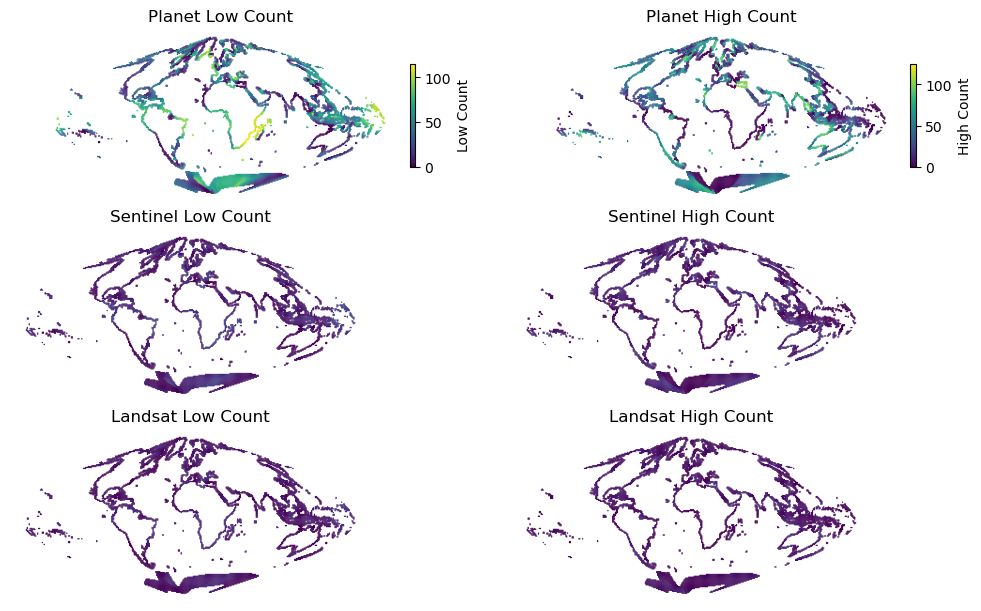

In [8]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

# ───────────────────────────────────────────────────────────────
# 1. polygons → centroids and join metrics
# ───────────────────────────────────────────────────────────────
gdf_pts = (
    grid_df.to_crs(all_grids_df.crs)        # CRS match
           .assign(geometry=lambda d: d.geometry.centroid)
           .merge(tide_df, on="cell_id")
)

# ───────────────────────────────────────────────────────────────
# 2. axes layout: rows = sensors, cols = metrics
# ───────────────────────────────────────────────────────────────
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["count"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high")]

nrows, ncols  = len(sensors), len(metrics)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 5, nrows * 2),
    constrained_layout=True,
)

# ───────────────────────────────────────────────────────────────
# 3.  loop over columns (metrics) to set a shared scale per column
# ───────────────────────────────────────────────────────────────
cmap = "viridis"

for c, metric in enumerate(metrics):
    # shared vmin/vmax across sensors for this metric
    col_values = [f"{sat}_{metric}" for sat in sensors]
    vmin = gdf_pts[col_values].min().min()
    vmax = gdf_pts[col_values].max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for r, sensor in enumerate(sensors):
        ax      = axes[r, c]
        colname = f"{sensor}_{metric}"

        gdf_pts.plot(
            column     = colname,
            ax         = ax,
            cmap       = cmap,
            norm       = norm,
            marker     = "o",
            markersize = 1,
            linewidth  = 0,
            legend     = False,
        )

        # titles: top row gets metric title; first column gets sensor label
        ax.set_title(f"{sensor.title()} {metric.replace('_', ' ').title()}")
        ax.axis("off")

    # add ONE colour-bar for the whole column
    sm = ScalarMappable(norm=norm, cmap=cmap);  sm.set_array([])
    cax = fig.colorbar(sm, ax=axes[0, c], shrink=0.6, pad=0.02, location="right")
    cax.ax.set_ylabel(metric.replace('_', ' ').title())

# plt.savefig("/Users/kyledorman/Desktop/tide_count.png", dpi=300)
plt.show()

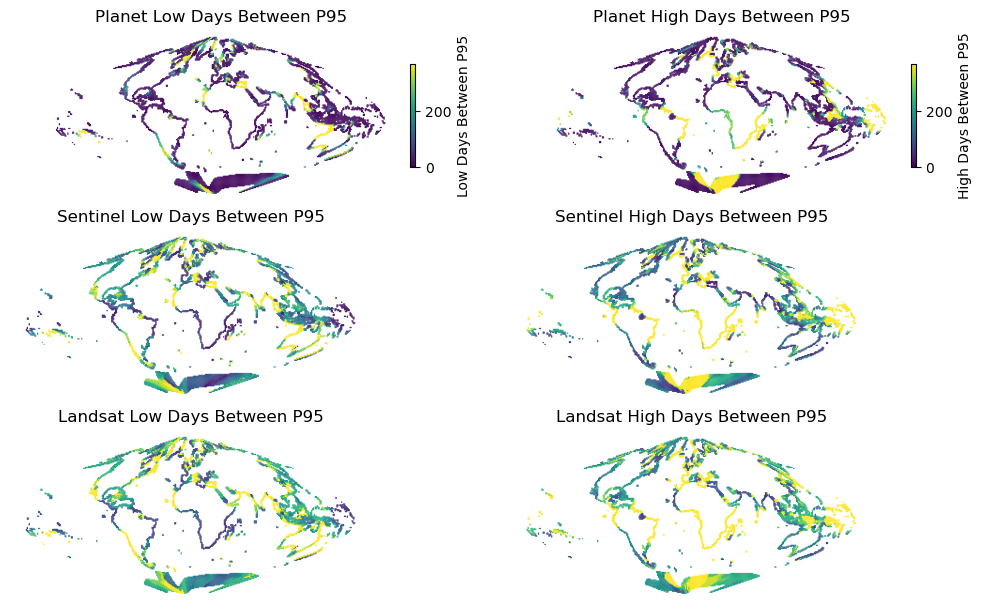

In [9]:
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import matplotlib as mpl

# ───────────────────────────────────────────────────────────────
# 1. polygons → centroids and join metrics
# ───────────────────────────────────────────────────────────────
gdf_pts = (
    grid_df.to_crs(all_grids_df.crs)        # CRS match
           .assign(geometry=lambda d: d.geometry.centroid)
           .merge(tide_df, on="cell_id")
)

# ───────────────────────────────────────────────────────────────
# 2. axes layout: rows = sensors, cols = metrics
# ───────────────────────────────────────────────────────────────
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["days_between_p95"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high")]

nrows, ncols  = len(sensors), len(metrics)
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * 5, nrows * 2),
    constrained_layout=True,
)

# ───────────────────────────────────────────────────────────────
# 3.  loop over columns (metrics) to set a shared scale per column
# ───────────────────────────────────────────────────────────────
cmap = "viridis"

for c, metric in enumerate(metrics):
    # shared vmin/vmax across sensors for this metric
    col_values = [f"{sat}_{metric}" for sat in sensors]
    vmin = 0 # gdf_pts[col_values].min().min()
    vmax = gdf_pts[col_values].max().max()
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    for r, sensor in enumerate(sensors):
        ax      = axes[r, c]
        colname = f"{sensor}_{metric}"

        gdf_pts.plot(
            column     = colname,
            ax         = ax,
            cmap       = cmap,
            norm       = norm,
            marker     = "o",
            markersize = 1,
            linewidth  = 0,
            legend     = False,
        )

        # titles: top row gets metric title; first column gets sensor label
        ax.set_title(f"{sensor.title()} {metric.replace('_', ' ').title()}")
        ax.axis("off")

    # add ONE colour-bar for the whole column
    sm = ScalarMappable(norm=norm, cmap=cmap);  sm.set_array([])
    cax = fig.colorbar(sm, ax=axes[0, c], shrink=0.6, pad=0.02, location="right")
    cax.ax.set_ylabel(metric.replace('_', ' ').title())

# plt.savefig("/Users/kyledorman/Desktop/tide_days_between_p95.png", dpi=300)
plt.show()

In [ ]:
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["count"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("low", "high")]

for metric in metrics:
    print(metric, "% No observations")
    for sensor in sensors:
        print(sensor, round(100 * (tide_df[f'{sensor}_{metric}'] == 0).sum() / len(tide_df), 1))

In [11]:
sensors       = ["planet", "sentinel", "landsat"]
base_metrics  = ["days_between_p95"]
metrics       = [f"{lvl}_{m}" for m in base_metrics for lvl in ("mid",)]

for metric in metrics:
    print(metric, "% > 100 days")
    for sensor in sensors:
        print(sensor, round(100 * (tide_df[f'{sensor}_{metric}'] > 100).sum() / len(tide_df), 1))

mid_days_between_p95 % > 100 days
planet 0.0
sentinel 0.7
landsat 0.9


In [15]:
[a for a in tide_df.columns if 'days_between_p95' in a]

['planet_low_days_between_p95',
 'planet_high_days_between_p95',
 'planet_mid_days_between_p95',
 'sentinel_low_days_between_p95',
 'sentinel_high_days_between_p95',
 'sentinel_mid_days_between_p95',
 'landsat_low_days_between_p95',
 'landsat_high_days_between_p95',
 'landsat_mid_days_between_p95']

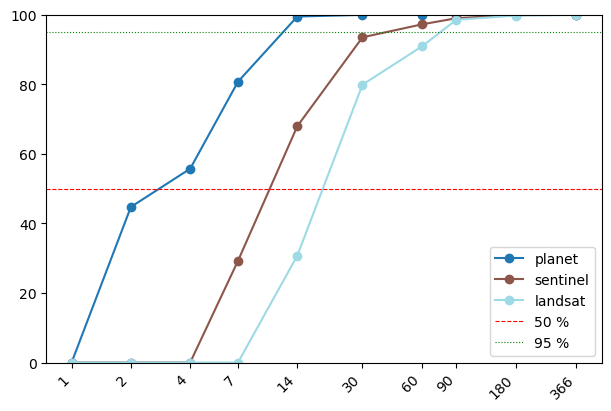

In [21]:
plt_bin_edges = np.array([0, 4, 7, 14, 30, 60, 90, 366], dtype=np.int32)
bin_edges = np.array([0, 1, 2, 4, 7, 14, 30, 60, 90, 180, 366], dtype=np.int32)
bin_right = bin_edges[1:]  # right edge of each bar
cmap = plt.get_cmap("tab20", 3)

# Cumulative sum plot
fig, ax = plt.subplots(
    1,
    1,
    figsize=(6, 4),
    constrained_layout=True,
)

for i, sensor in enumerate(sensors):
    counts, _ = np.histogram(tide_df[f'{sensor}_mid_days_between_p95'], bin_edges)
    cumsum = np.cumsum(counts)
    total = cumsum[-1] if cumsum[-1] else 1.0  # prevent divide-by-zero
    cumsum_pct = cumsum / total * 100.0  # → 0-100 %
    
    color = cmap(i)  # consistent color per year
    ax.plot(
        bin_right,
        cumsum_pct,
        marker="o",
        linestyle="-",
        color=color,
        label=sensor,
    )


ax.set_ylim(0, 100)
ax.set_xscale("log")
ax.set_xticks(bin_edges[1:])
ax.set_xticklabels(
    [f"{b:g}" for b in bin_edges[1:]],
    rotation=45,
    ha="right",
)
from matplotlib.ticker import NullLocator
ax.xaxis.set_minor_locator(NullLocator())
# ax.tick_params(axis="both", labelsize=8)
ax.axhline(50, linestyle="--", linewidth=0.8, label="50 %", color="red")
ax.axhline(95, linestyle=":", linewidth=0.8, label="95 %", color="green")
ax.legend()

plt.show()